In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [247]:
heartDf = pd.read_csv('./heart.csv')
heartDf.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [248]:
renamedHeartDf = heartDf.rename(columns={
  "cp": "chestPain", 
  "trtbps": "restingBloodPressure",
  "chol": "cholesterol",
  "fbs": "fastingBloodSugar",
  "restecg": "restEcg",
  "thalachh": "maxHeartRateAchieved",
  "exng": "exerciceInducedAngina",
  "oldpeak": "stDepression",
  "slp": "stSegmentSlope",
  "caa": "majorVesselsNum",
  "thall": "thalassemia",
  "output": "heartDisease"
})
renamedHeartDf.head()

,age,sex,chestPain,restingBloodPressure,cholesterol,fastingBloodSugar,restEcg,maxHeartRateAchieved,exerciceInducedAngina,stDepression,stSegmentSlope,majorVesselsNum,thalassemia,heartDisease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot:>

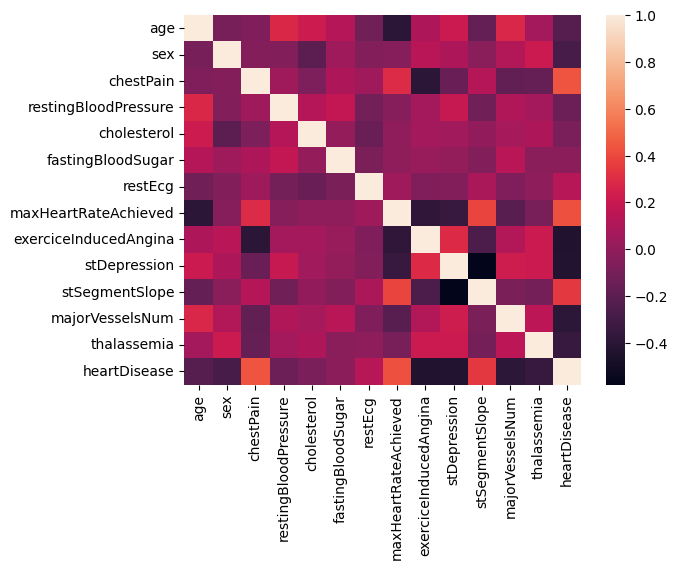

In [249]:
corr = renamedHeartDf.corr()
sns.heatmap(corr)

In [250]:
allCorr = corr.heartDisease[(corr.heartDisease.abs() > 0.3) & (corr.heartDisease.abs() < 1)].index
positiveCorr = corr.heartDisease[(corr.heartDisease > 0.3) & (corr.heartDisease.abs() < 1)].index
negativeCorr = corr.heartDisease[corr.heartDisease < -0.3].index
print(allCorr)
print(positiveCorr)
print(negativeCorr)

Index(['chestPain', 'maxHeartRateAchieved', 'exerciceInducedAngina',
       'stDepression', 'stSegmentSlope', 'majorVesselsNum', 'thalassemia'],
      dtype='object')
Index(['chestPain', 'maxHeartRateAchieved', 'stSegmentSlope'], dtype='object')
Index(['exerciceInducedAngina', 'stDepression', 'majorVesselsNum',
       'thalassemia'],
      dtype='object')


In [251]:
targetResults = renamedHeartDf.heartDisease
renamedHeartDf.drop("heartDisease", axis=1, inplace=True)
dataMap = {
  "allDataDf": [],
  "allCorrDf": allCorr,
  "positiveCorrDf": positiveCorr,
  "negativeCorrDf": negativeCorr,
}

def filterData(df, columns):
  if len(columns) == 0: return df
  else: return df[columns]

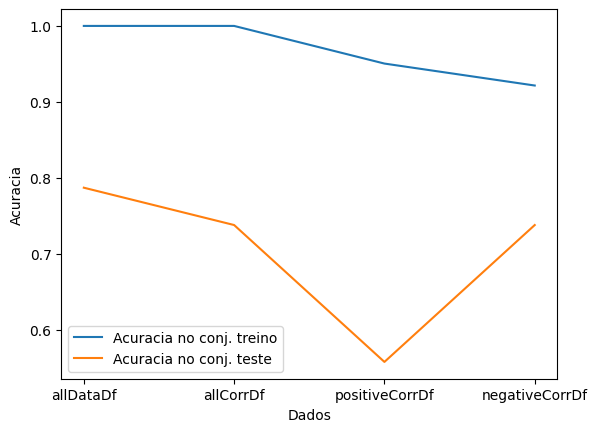

In [252]:
training_accuracy = []
test_accuracy = []

data_train, data_test, results_train, results_test = train_test_split(
  renamedHeartDf, 
  targetResults,
  test_size=0.2
)

for data in dataMap:
  tree = DecisionTreeClassifier()
  tree.fit(filterData(data_train, dataMap[data]),results_train)
  training_accuracy.append(tree.score(filterData(data_train, dataMap[data]),results_train))
  test_accuracy.append(tree.score(filterData(data_test, dataMap[data]), results_test))

plt.plot(dataMap.keys(),training_accuracy, label='Acuracia no conj. treino')
plt.plot(dataMap.keys(),test_accuracy, label='Acuracia no conj. teste')
plt.ylabel('Acuracia')
plt.xlabel('Dados')
plt.legend()

In [253]:
file = open('./output.csv', 'a')
file.write('df,train_score,test_score\n')

for i in range(0, 100):
  data_train, data_test, results_train, results_test = train_test_split(
    renamedHeartDf, 
    targetResults,
    test_size=0.2
  )

  for data in dataMap:
    tree = DecisionTreeClassifier()
    tree.fit(filterData(data_train, dataMap[data]),results_train)
    train_score = tree.score(filterData(data_train, dataMap[data]),results_train)
    test_score = tree.score(filterData(data_test, dataMap[data]), results_test)
    file.write("%s,%.2f,%.2f\n" % (data, train_score,test_score))

file.close()

In [254]:
resultsDf = pd.read_csv('./output.csv')

In [255]:
resultsDf.head()

,df,train_score,test_score
0,allDataDf,1.00,0.75
1,allCorrDf,1.00,0.77
2,positiveCorrDf,0.93,0.70
3,negativeCorrDf,0.93,0.77
4,allDataDf,1.00,0.84


In [256]:
resultsDf.groupby('df').test_score.agg([min, max, 'mean'])

,min,max,mean
df,,,
allCorrDf,0.64,0.89,0.7568
allDataDf,0.56,0.87,0.7502
negativeCorrDf,0.59,0.90,0.7427
positiveCorrDf,0.56,0.79,0.6864
